In [38]:
from altaipony.injrecanalysis import plot_heatmap, tile_up_injection_recovery
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
df = pd.read_csv("/work1/eilin/TESS_UCDs/injrec/nodup_10000_000303978478_s0002.csv")


In [48]:
df = df.drop_duplicates()
df.shape

(1546, 16)

In [53]:
dff, val = tile_up_injection_recovery(df, "recovery_probability",ampl_bins=10, dur_bins=10
                                     )

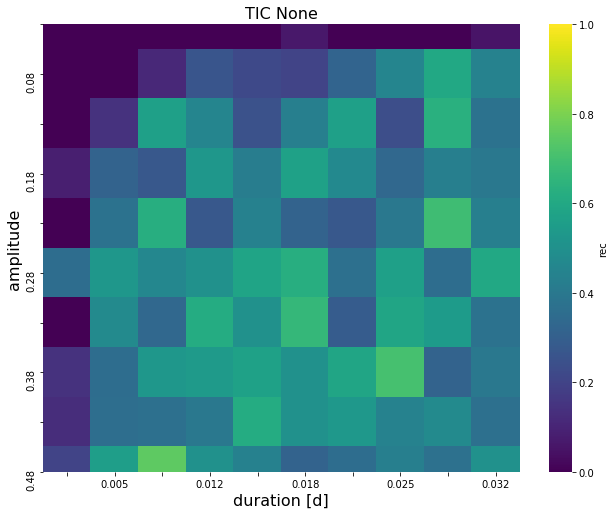

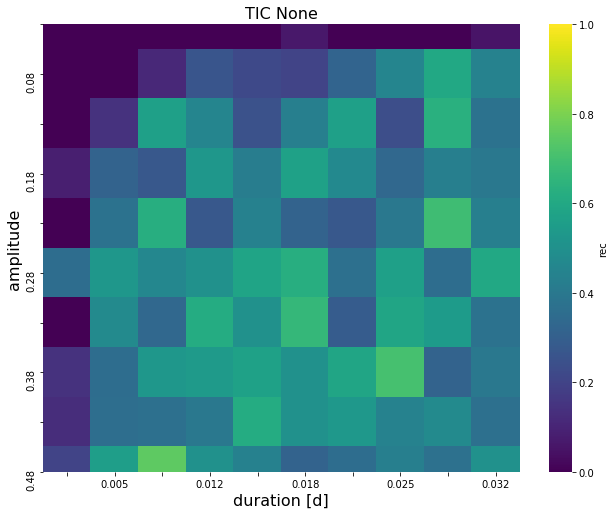

In [54]:
plot_heatmap(dff, val)